# Мониторинг лесных пожаров по фото с предобученной моделью

Прототип IT‑решения для мониторинга экосистем: по изображению определить, есть ли на нём **лесной пожар**.

**Формат результата:** класс (`fire` / `no_fire`) и вероятность.


## Бизнес-постановка задачи

Лесные пожары наносят ущерб экосистемам, животным и людям. Раннее обнаружение пожара позволяет:
- ускорить реагирование служб;
- снизить экологический и экономический ущерб;
- автоматизировать мониторинг больших территорий (дроны, камеры наблюдения, спутники).


## Постановка задачи в терминах Data Science

- Область: **Computer Vision (CV)**
- Тип: **бинарная классификация изображений**
- Вход: изображение
- Выход: класс `fire/no_fire` + вероятность

> В проекте используется **готовая предобученная модель** (без дообучения).


## Импорты и настройки

In [7]:
# Если запускаете в чистой среде, установите зависимости:
# pip install -r requirements.txt

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from sklearn.metrics import classification_report, confusion_matrix

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE


'cpu'

## Загрузка предобученной модели

В этом прототипе используем готовую модель с Hugging Face, обученную на данных о пожарах.

Пример подходящих моделей (можно заменить на любую совместимую):
- `Gurveer05/vit-base-patch16-224-in21k-fire-detection`
- `arnaucas/wildfire-classifier`

Ниже по умолчанию подключаем ViT‑модель для детекции пожара.

In [8]:
MODEL_ID = 'Gurveer05/vit-base-patch16-224-in21k-fire-detection'

processor = AutoImageProcessor.from_pretrained(MODEL_ID, use_fast=False)
model = AutoModelForImageClassification.from_pretrained(MODEL_ID).to(DEVICE)
model.eval()

id2label = model.config.id2label
id2label


{0: 'LABEL_0', 1: 'LABEL_1'}

## Данные для демонстрации

Ожидаемая структура папок с изображениями:

```
data/
  fire/      # изображения с пожаром
  no_fire/   # изображения без пожара
```

Положите несколько `.jpg/.png` файлов в каждую папку.


In [9]:
DATA_DIR = (Path('..') / 'data').resolve()  # notebooks/ -> ../data
FIRE_DIR = DATA_DIR / 'fire'
NOFIRE_DIR = DATA_DIR / 'no_fire'

print('DATA_DIR:', DATA_DIR)
print('fire images:', len(list(FIRE_DIR.glob('*'))))
print('no_fire images:', len(list(NOFIRE_DIR.glob('*'))))


DATA_DIR: /Users/anastasiakolevatykh/PycharmProjects/wildfire_image_detection/data
fire images: 2
no_fire images: 2


## Функции: предобработка и инференс

In [10]:
def load_image(path: Path) -> Image.Image:
    return Image.open(path).convert('RGB')

def predict_image(img):
    # 1) если передали путь вместо PIL
    if isinstance(img, (str, Path)):
        img = Image.open(img)

    # 2) гарантируем корректный формат
    img = img.convert("RGB")

    # 3) во многих версиях transformers безопаснее передавать список [img]
    inputs = processor(images=[img], return_tensors="pt")

    # 4) BatchFeature не всегда поддерживает .to(), переносим тензоры вручную
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0].detach().cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_label = model.config.id2label[pred_id]
    confidence = float(probs[pred_id])
    return pred_label, confidence, probs


## Пример предсказания для одного изображения

Using file: /Users/anastasiakolevatykh/PycharmProjects/wildfire_image_detection/data/fire/fire_forest2.jpeg


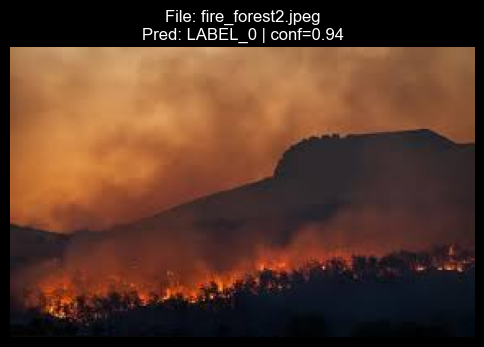

Predicted: LABEL_0
Confidence: 0.9426
All probs: {'LABEL_0': 0.9426449537277222, 'LABEL_1': 0.05735502764582634}


In [11]:

valid_ext = {".jpg", ".jpeg", ".png", ".webp"}

example_paths = (
    list(FIRE_DIR.glob("*")) +
    list(NOFIRE_DIR.glob("*"))
)

example_paths = [
    p for p in example_paths
    if p.is_file() and p.suffix.lower() in valid_ext
]

if not example_paths:
    raise FileNotFoundError(
        "В папках data/fire и data/no_fire нет изображений (.jpg/.png/.webp)"
    )

print("Using file:", example_paths[0])
example_path = example_paths[0]
img = load_image(example_path)
pred_label, confidence, probs = predict_image(img)

plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f'File: {example_path.name}\nPred: {pred_label} | conf={confidence:.2f}')
plt.show()

print('Predicted:', pred_label)
print('Confidence:', round(confidence, 4))
print('All probs:', {id2label[i]: float(p) for i, p in enumerate(probs)})


## Оценка качества на локальной выборке

Если у вас есть разметка через папки `fire/` и `no_fire/`, можно посчитать базовые метрики.
Это помогает показать, **где модель ошибается** и какие есть ограничения.

In [12]:
def collect_labeled_paths():
    samples = []
    for p in FIRE_DIR.glob('*'):
        if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}:
            samples.append((p, 'fire'))
    for p in NOFIRE_DIR.glob('*'):
        if p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}:
            samples.append((p, 'no_fire'))
    return samples

samples = collect_labeled_paths()
print('Total labeled samples:', len(samples))


Total labeled samples: 4


In [14]:
if len(samples) < 2:
    print('Недостаточно данных для оценки. Добавьте изображения в обе папки.')
else:
    y_true, y_pred = [], []
    for path, true_label in samples:
        img = load_image(path)
        pred_label, conf, _ = predict_image(img)

        # Нормализуем название класса модели к fire/no_fire
        norm = pred_label.lower().replace(' ', '').replace('-', '').replace('_', '')
        if 'nofire' in norm or 'normal' in norm:
            pred_bin = 'no_fire'
        elif 'fire' in norm or 'smoke' in norm:
            pred_bin = 'fire'
        else:
            pred_bin = 'fire' if 'fire' in norm else 'no_fire'

        y_true.append(true_label)
        y_pred.append(pred_bin)

    print(classification_report(
    y_true,
    y_pred,
    digits=4,
    zero_division=0
    ))
    cm = confusion_matrix(y_true, y_pred, labels=['fire', 'no_fire'])
    print('Confusion matrix (rows=true, cols=pred):')
    print(cm)


              precision    recall  f1-score   support

        fire     0.0000    0.0000    0.0000         2
     no_fire     0.5000    1.0000    0.6667         2

    accuracy                         0.5000         4
   macro avg     0.2500    0.5000    0.3333         4
weighted avg     0.2500    0.5000    0.3333         4

Confusion matrix (rows=true, cols=pred):
[[0 2]
 [0 2]]


## Интерпретация для мониторинга

Модель возвращает вероятность. В реальной системе мониторинга можно использовать порог:
- если `P(fire) >= 0.70` → автоматически формировать событие/оповещение;
- если `P(fire) < 0.70` → отправлять кадр на ручную проверку.

Такой подход снижает риск ложных срабатываний и повышает надежность мониторинга.

## Ограничения прототипа

- Возможны ошибки при тумане, дымке, закатном освещении, низком качестве изображения.
- Для производственного внедрения требуется расширенная валидация на данных конкретного региона/источника.
- Этот ноутбук — демонстрация интеграции **готовой предобученной модели** в пайплайн мониторинга.